In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
%cd gdrive
%cd MyDrive
%cd Colab Notebooks
%cd Impact-of-COVID19-and-WinterStorm

Mounted at /content/gdrive/
/content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/Colab Notebooks
/content/gdrive/MyDrive/Colab Notebooks/Impact-of-COVID19-and-WinterStorm


In [ ]:
!pip install adtk > /dev/null 2>&1

In [2]:
import os
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=True)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
cool_points=weather_austin_daily[weather_austin_daily<15]['2017-01-01 00:00:00+00:00':'2021-01-31 00:00:00+00:00']
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset



In [3]:
def prepare_data(service_point):
    sample=load_data(service_point)
    sample=sample.set_index(sample[sample.columns[0]])
    sample=sample[sample.columns[1:2]]
    sample=sample.resample('D').sum()
    return sample
def make_features(dataframe,time_level):
    s=dataframe
    start_time=s.index[0]
    end_time=s.index[-1]
    example_ts=s
    example_ts['dayofyear_cos']=np.cos(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['dayofyear_sim']=np.sin(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['month_cos']=np.cos(example_ts.index.month*(2.*np.pi/12))
    example_ts['month_sin']=np.sin(example_ts.index.month*(2.*np.pi/12))
    example_ts['year'] = example_ts.index.year

    for ts in example_ts.index:
        if time_level=='hourly':
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts] 
        else:
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts]

    return example_ts


In [4]:
def clean_data(data,servicepoint):
    data = data.rename(columns={list(data.columns.values)[0]: 'Energy_kwh'})
    data1=data[:'2021-02-10']
    bad_value=data1[data1.columns[0]].quantile(0.98)
    print('filter_value',bad_value)
    Index=data1[data1['Energy_kwh']>bad_value].index
    data1=data1.drop(Index)
    return pd.concat([data1,data['2021-02-11':'2021-02-22']])
def preprocess_data(servicepoint,df):
    s=df
    s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
    train_set=s['2018-01-01':'2021-02-10']
    test_set=s['2021-02-11':'2021-02-19']
    residential_train=make_features(train_set,'daily')
    residential_test=make_features(test_set,'daily')
    Q1=residential_train[residential_train.columns[0]].quantile(0.25)
    Q3=residential_train[residential_train.columns[0]].quantile(0.75)
    low_5=residential_train[residential_train['TMP']<=5]['Energy_kwh'].quantile(0.50)
    lower_bound=low_5
    IQR=Q3-Q1
    upper_bound=Q3+1.5*IQR
    Index=residential_train[(residential_train['Energy_kwh'] <Q1 ) & (residential_train['TMP'] <0) ].index
    print('dropped_points',len(Index))
    cleaned_train=residential_train.drop(Index,axis=0)
    cleaned_train1=pd.concat([cleaned_train,residential_test])
    return cleaned_train1


In [5]:
def prediction_model(service_point,df,visualize=True,calculate_metrics=None,metric=None):
    print('.....LOADING DATA.........')
    q=preprocess_data(service_point,df)
    
    train_below_5=q[q['TMP']<=5][:'2020-01-01']
    train_above_5=q[q['TMP']>5][:'2020-01-01']

    
    m_below,b_below = np.polyfit(train_below_5['TMP'], train_below_5['Energy_kwh'], 1)
    if visualize:
        plt.scatter(train_below_5['TMP'], train_below_5['Energy_kwh'])
        plt.plot(train_below_5['TMP'], m_below*train_below_5['TMP'] +b_below,color='red')
        plt.show()
        print(train_below_5['TMP'].corr(train_below_5['Energy_kwh']))

    m_above,m1_above,b_above = np.polyfit(train_above_5['TMP'], train_above_5['Energy_kwh'], 2)
    if visualize:
        plt.scatter(train_above_5['TMP'], train_above_5['Energy_kwh'])
        plt.plot(train_above_5['TMP'], m_above*train_above_5['TMP']**2 + m1_above*train_above_5['TMP'] + b_above,color='red')
        plt.show()
        print(train_above_5['TMP'].corr(train_above_5['Energy_kwh']))
    
        print('...............VIZ DONE.............')
    
    test_below_5=q[q['TMP']<=5]['2020-01-01':]
    test_above_5=q[q['TMP']>5]['2020-01-01':]

    #SCALING 
    print('...........STARTED SCALING')
    scaler_below = MinMaxScaler()
    scaler_pred_below=MinMaxScaler()
    scaler_pred_below.fit(train_below_5[['Energy_kwh']])
    
    train_below_5_scaled = scaler_below.fit_transform(train_below_5.to_numpy())
    train_below_5_scaled = pd.DataFrame(train_below_5_scaled, columns=train_below_5.columns,index=train_below_5.index)
    
    test_below_5_scaled = scaler_below.transform(test_below_5.to_numpy())
    test_below_5_scaled = pd.DataFrame(test_below_5_scaled, columns=test_below_5.columns,index=test_below_5.index)
    
    scaler_above = MinMaxScaler()
    scaler_pred_above=MinMaxScaler()
    scaler_pred_above.fit(train_above_5[['Energy_kwh']])
    
    train_above_5_scaled = scaler_above.fit_transform(train_above_5.to_numpy())
    train_above_5_scaled = pd.DataFrame(train_above_5_scaled, columns=train_above_5.columns,index=train_above_5.index)
    
    test_above_5_scaled = scaler_above.transform(test_above_5.to_numpy())
    test_above_5_scaled = pd.DataFrame(test_above_5_scaled, columns=test_above_5.columns,index=test_above_5.index)
    
    print('..........SCALING DONE.........')
    
    ## FITTING
    lr_below_5_score_model=LinearRegression()
    X5_train, X5_test, y5_train, y5_test = train_test_split(train_below_5_scaled[['year','TMP']], train_below_5_scaled[['Energy_kwh']], test_size=0.2, random_state=42)
    lr_below_5_score_model.fit(X5_train,y5_train)
    print(' holdout_score_for below 5',lr_below_5_score_model.score(X5_test,y5_test))
    Lr_below_5=LinearRegression().fit(train_below_5_scaled[['year','TMP']], train_below_5_scaled[['Energy_kwh']])
    cv_score_below_5=cross_val_score(LinearRegression(), train_below_5_scaled[['year','TMP']], train_below_5_scaled[['Energy_kwh']], cv=5, scoring='r2')
    print('cv_score_below_5',cv_score_below_5)
  
    rf_model=RandomForestRegressor()
    X_train, X_test, y_train, y_test = train_test_split(train_above_5_scaled[train_above_5_scaled.columns[1:]], train_above_5_scaled[['Energy_kwh']], test_size=0.2, random_state=42)
    rf_model.fit(X_train,y_train)
    print(' holdout_score_for above 5',rf_model.score(X_test,y_test))
    final_rf=RandomForestRegressor()
    final_rf.fit(train_above_5_scaled[train_above_5_scaled.columns[1:]], train_above_5_scaled[['Energy_kwh']])
    cv_score_above_5=cross_val_score(RandomForestRegressor(), train_above_5_scaled[train_above_5_scaled.columns[1:]], train_above_5_scaled[['Energy_kwh']], cv=5, scoring='r2')
    print('cv_score_above_5',cv_score_above_5)
    ## PREDICTION
    below_5_predictions_sc=scaler_pred_below.inverse_transform(np.array(Lr_below_5.predict(test_below_5_scaled[['year','TMP']])).reshape(-1,1))
    
    below_5_predictions=pd.DataFrame(below_5_predictions_sc,
                                     index=test_below_5_scaled.index)
    
    test_below_5_scaled2=pd.DataFrame(scaler_below.inverse_transform(test_below_5_scaled),columns=test_below_5_scaled.columns,
                                      index=test_below_5_scaled.index)
    below_5_predictions1=test_below_5_scaled2.merge(below_5_predictions,how='inner',left_index=True,right_index=True)
        
        
    
    test_rf_features = test_above_5_scaled[test_above_5_scaled.columns[1:]]
    above_5_predictions_sc=scaler_pred_above.inverse_transform(np.array(final_rf.predict(test_rf_features)).reshape(-1,1))

    above_5_predictions=pd.DataFrame(above_5_predictions_sc,
                                     index=test_above_5_scaled.index)
    test_above_5_scaled2=pd.DataFrame(scaler_above.inverse_transform(test_above_5_scaled),columns=test_above_5_scaled.columns,
                                      index=test_above_5_scaled.index)
    
    above_5_predictions1=test_above_5_scaled2.merge(above_5_predictions,how='inner',left_index=True,right_index=True)
    
    ## JOINING EVERYTHING AND CONVERTING BACK
    total_predictions=pd.concat([above_5_predictions1,below_5_predictions1])[['Energy_kwh','TMP',0]]
    total_predictions1=total_predictions[total_predictions[0]>0].sort_index().rename(
                                                            columns={0: 'prediction'})
    total_predictions1['difference']=total_predictions1['prediction']-total_predictions1['Energy_kwh']
    total_predictions2=total_predictions1[['Energy_kwh','prediction','difference']]
    for ts in total_predictions2.index:
      total_predictions2.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts] 

    
    if calculate_metrics and metric:
        predic=total_predictions1['prediction']['2021-02-11':'2021-02-19']
        real=  total_predictions1['Energy_kwh']['2021-02-11':'2021-02-19']
        if metric=='perc_diff':
            result=100*(predic-real)/real
        elif metric=='difference(z_score)':
            metric_result=predic-real
            result=(metric_result-metric_result.mean())/metric_result.std()
        elif metric=='perc_diff(reverse)':
            result=100*(real-predic)/predic
        di=pd.DataFrame(result)
        di['timestamp']=di.index
        di1=di.rename(columns={0:service_point})
        return di1.reset_index().iloc[:,1:].set_index('timestamp',drop=True)
    else:
        return total_predictions2

In [6]:
servicepoint=1583
df=pd.read_csv(f'{servicepoint}.csv')
df[df.columns[0]]=pd.to_datetime(df[df.columns[0]])
df1=df.set_index(f'{-servicepoint} kWh DateTime',drop=True)['2018':].resample('H').sum()
df2=clean_data(df1,servicepoint)
df3=prediction_model(-servicepoint,df2,visualize=False,calculate_metrics=None,metric=None)
df3['2021-02-10':].resample('D').sum()

filter_value 209.89498207092277
.....LOADING DATA.........
dropped_points 18
...........STARTED SCALING
..........SCALING DONE.........
 holdout_score_for below 5 0.2781813488580258
cv_score_below_5 [ 0.39881254  0.16736611 -0.05507573  0.30506861 -0.51959461]
 holdout_score_for above 5 0.5807310741935277
cv_score_above_5 [0.32995657 0.44266071 0.02095464 0.50806823 0.56892526]


,Energy_kwh,prediction,difference,TMP
-1583 kWh DateTime,,,,
2021-02-10,1921.707199,875.307769,-1046.399430,110.3
2021-02-11,6726.203194,2209.553557,-4516.649637,39.1
2021-02-12,7226.377350,2497.420665,-4728.956685,-10.0
2021-02-13,7238.172173,2669.202870,-4568.969302,-39.3
2021-02-14,7671.822403,2785.874061,-4885.948342,-59.2
2021-02-15,7038.653778,3689.342929,-3349.310849,-213.3
2021-02-16,5502.928398,3648.889099,-1854.039299,-206.4
2021-02-17,5782.335770,2770.044301,-3012.291468,-56.5
2021-02-18,6769.274239,2713.174425,-4056.099814,-46.8


In [7]:
df_pred=df3[['difference']]
df_pred.head(2)

,difference
-1583 kWh DateTime,
2020-01-01 00:00:00,0.070398
2020-01-01 01:00:00,2.047373


In [8]:
scaler = StandardScaler()
X_train=df_pred[:'2021-02-10']
length = len(X_train)
split_index = int(length * 0.8)
split_index = split_index - split_index % 24
print(df_pred[split_index:split_index+1])
X_train1 = scaler.fit_transform(X_train[:split_index])
X_val = scaler.transform(X_train[split_index:split_index + (len(X_train) - split_index) // 24 * 24])
X_test=scaler.transform(df_pred['2021-02-11 0:00:00':'2021-02-20'])

                     difference
-1583 kWh DateTime             
2020-11-17 10:00:00  -57.599735


In [9]:
print(X_train1.shape)
print(X_val.shape)
print(X_test.shape)

(7368, 1)
(1848, 1)
(216, 1)


In [10]:
train_sequences = np.split(X_train1, X_train1.shape[0]//24)
train_sequences = np.stack(train_sequences, axis=0)
val_sequences = np.split(X_val, X_val.shape[0]//24)
val_sequences = np.stack(val_sequences, axis=0)
test_sequences = np.split(X_test, X_test.shape[0]//24)
test_sequences = np.stack(test_sequences, axis=0)
print(train_sequences.shape)
print(val_sequences.shape)
print(test_sequences.shape)

(307, 24, 1)
(77, 24, 1)
(9, 24, 1)


In [11]:
def total_trainable_parameters(model):
    total = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
          print(name, param.shape)
          total += param.numel()
    print()
    print(f'Total trainable parameters of {model.__class__.__name__} is', '\t', total)

In [12]:

import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        attention_weights = torch.matmul(query, key.transpose(0,1)) / torch.sqrt(torch.tensor(self.hidden_size))
        attention_weights = F.softmax(attention_weights, dim=1)
        
        attended_representation = torch.matmul(attention_weights, value)
        
        return attended_representation

In [48]:
class Encoder(nn.Module):
  def __init__(self, n_features, embedding_dim,num_layers,dropout_rate):
    super(Encoder, self).__init__()
    self.num_layers=num_layers
    self.n_features= n_features
    self.embedding_dim=embedding_dim
    self.hidden_dim = embedding_dim
    self.lstm_encoder = nn.ModuleList()
    self.dropout_encoder = nn.ModuleList()
    self.relu=nn.ReLU()
    self.lstm_encoder.append(nn.LSTM(input_size=self.n_features,hidden_size=self.hidden_dim,batch_first=True))
    self.dropout_encoder.append(nn.Dropout(dropout_rate))
    for i in range(1,self.num_layers):
        self.hidden_dim = self.hidden_dim // 2
        self.lstm_encoder.append(nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_dim,batch_first=True))
        self.embedding_dim=self.hidden_dim
        if i<self.num_layers-1:
          self.dropout_encoder.append(nn.Dropout(dropout_rate))

  def forward(self, x):
    x=x.unsqueeze(0)
    h0 = torch.zeros(1, x.size(0), self.embedding_dim)
    c0 = torch.zeros(1, x.size(0), self.embedding_dim)
    for i in range(self.num_layers):
        x, (hidden_n, _) = self.lstm_encoder[i](x,(h0,c0))
        x=self.relu(x)
        if i<self.num_layers-1:
          x = self.dropout_encoder[i](x)
        h0, c0 = hidden_n, _

    encoded = x.squeeze(0)
    return encoded


class Decoder(nn.Module):
  def __init__(self, seq_len,input_dim, n_features,num_layers,dropout_rate):
    super(Decoder, self).__init__()
    self.seq_len=seq_len
    self.input_dim=input_dim
    self.hidden_dim = input_dim**2
    self.num_layers=num_layers
    self.n_features = n_features
    self.lstm_decoder = nn.ModuleList()
    self.dropout_decoder = nn.ModuleList()
    self.lstm_decoder.append(nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, batch_first=True))
    self.relu=nn.ReLU()
    self.dropout_decoder.append(nn.Dropout(dropout_rate))
    for i in range(1,self.num_layers):
      self.output_hidden_dim=self.hidden_dim//2
      self.lstm_decoder.append(nn.LSTM(input_size=self.hidden_dim, hidden_size=self.output_hidden_dim, batch_first=True))
      self.hidden_dim=self.output_hidden_dim
      if i<self.num_layers-1:
          self.dropout_decoder.append(nn.Dropout(dropout_rate))
    self.output_layer = nn.Linear(self.output_hidden_dim, n_features)
  def forward(self, x):
    x=x.unsqueeze(0)
    h0 = torch.zeros(1, x.size(0), self.hidden_dim)
    c0 = torch.zeros(1, x.size(0), self.hidden_dim)
    #x=x.repeat(1,self.seq_len,1)
    for i in range(self.num_layers):
        x, (hidden_n, _) = self.lstm_decoder[i](x,(h0,c0))
        x=self.relu(x)
        h0, c0 = hidden_n, _
        if i<self.num_layers-1:
          x = self.dropout_decoder[i](x)
    return self.output_layer(x)



class RecurrentAutoencoder(nn.Module):
  def __init__(self,seq_len, n_features, embedding_dim,num_layers,dropout_rate):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder( n_features,embedding_dim,num_layers,dropout_rate)
    self.output_encoder_shape=embedding_dim//(2**(num_layers-1))
    self.attention=SelfAttention(embedding_dim)
    self.decoder = Decoder(seq_len,self.output_encoder_shape, n_features,num_layers,dropout_rate)
  def forward(self, x):
    x = self.encoder(x)
    x= self.attention(x)
    x = self.decoder(x)
    return x

In [33]:
y=val_sequences[20]
y1 = torch.from_numpy(y).float()
encoder=Encoder(1,64,3,0.2)
attention=SelfAttention(64)
print(y1.shape)
s2=encoder(y1)
print(s2.shape)
s3=attention(s2)
"""hidden_size=64
query = nn.Linear(hidden_size, hidden_size)
key = nn.Linear(hidden_size, hidden_size)
value = nn.Linear(hidden_size, hidden_size)
wt=torch.matmul(query(s2), key(s2).transpose(0,1))
g=F.softmax(wt,dim=1)
s2_=torch.matmul(wt, value(s2))"""
decoder=Decoder(24,64,2,1,0.2)
s4=decoder(s3)
s4.shape


torch.Size([24, 1])


RuntimeError: ignored

In [ ]:
rnn_model = RecurrentAutoencoder(seq_len=24,n_features=1, embedding_dim=32,num_layers=2,dropout_rate=0.2)
total_trainable_parameters(rnn_model)
rnn_model

Epoch 0-, Training_loss : 13.764 ,Validation_loss : 14.2036
Epoch 1-, Training_loss : 12.914 ,Validation_loss : 12.0515
Epoch 2-, Training_loss : 10.3487 ,Validation_loss : 8.3809
Epoch 3-, Training_loss : 7.2203 ,Validation_loss : 7.4932
Epoch 4-, Training_loss : 7.0006 ,Validation_loss : 7.354
Epoch 5-, Training_loss : 5.1173 ,Validation_loss : 6.2993
Epoch 6-, Training_loss : 4.705 ,Validation_loss : 5.0236
Epoch 7-, Training_loss : 3.6522 ,Validation_loss : 4.2208
Epoch 8-, Training_loss : 3.1079 ,Validation_loss : 3.996
Epoch 9-, Training_loss : 2.7978 ,Validation_loss : 5.5173
Epoch 10-, Training_loss : 2.4943 ,Validation_loss : 4.9105
Epoch 11-, Training_loss : 2.1986 ,Validation_loss : 3.9558
Epoch 12-, Training_loss : 1.9382 ,Validation_loss : 3.2049
Epoch 13-, Training_loss : 1.965 ,Validation_loss : 2.9754
Epoch 14-, Training_loss : 1.665 ,Validation_loss : 3.2509
Epoch 15-, Training_loss : 1.6729 ,Validation_loss : 2.6657
Epoch 16-, Training_loss : 1.5223 ,Validation_loss :

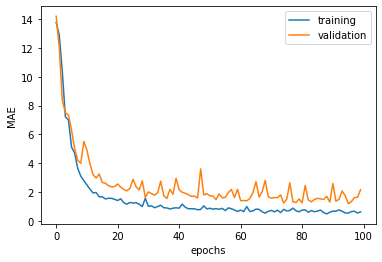

In [ ]:
criterion = nn.L1Loss(reduction='sum')
train_g=[]
val_g=[]
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
total_epochs=100
def train_model(data,model,epoch,total_epochs):
    model=model.train()
    trainloss=0.0
    len=data.shape[0]
    for batch in data:
      x1 = torch.from_numpy(batch).float()
      optimizer.zero_grad()
      outputs = model(x1)
      loss = criterion(outputs, x1)
      loss.backward()
      optimizer.step()
      trainloss+=loss.item()
    return round(trainloss/len,4)
def val_model(data,model,epoch,total_epochs):
    model.eval()
    valloss=0.0
    len=data.shape[0]
    with torch.no_grad():
      for batch in data:
        x1 = torch.from_numpy(batch).float()
        outputs = model(x1)
        loss = criterion(outputs, x1)
        valloss+=loss.item()
    return round(valloss/len,4)
for i in range(total_epochs):
  train_loss=train_model(train_sequences,rnn_model,i,total_epochs)
  val_loss=val_model(val_sequences,rnn_model,i,total_epochs)
  print(f'Epoch {i}-, Training_loss : {train_loss} ,Validation_loss : {val_loss}')
  train_g.append(train_loss)
  val_g.append(val_loss)
plt.plot(range(total_epochs),train_g,label='training')
plt.plot(range(total_epochs),val_g,label='validation')
plt.xlabel('epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
def find_threshold(model, data):
    criterion = nn.L1Loss(reduction='sum')
    errors = []
    model.eval()
    len=data.shape[0]
    with torch.no_grad():
      for batch in tqdm(data):
        x1 = torch.from_numpy(batch).float()
        outputs = model(x1)
        loss = criterion(outputs, x1)
        errors.append(loss.item())
    return np.quantile(errors, 0.95)
th=find_threshold(rnn_model,val_sequences)
th

100%|██████████| 77/77 [00:00<00:00, 493.26it/s]


4.083219051361084

In [ ]:
def predict_anomaly(model, data,threshold):
    criterion = nn.L1Loss(reduction='sum')
    errors = []
    anomalies =[]
    model.eval()
    len=data.shape[0]
    with torch.no_grad():
      for batch in tqdm(data):
        x1 = torch.from_numpy(batch).float()
        outputs = model(x1)
        loss = criterion(outputs, x1)
        errors.append(loss.item())
        if loss > threshold:
            anomalies.append(1)
        else:
            anomalies.append(0)
    df = pd.DataFrame({'error': errors, 'anomaly': anomalies},index=df3['2021-02-11 0:00:00':'2021-02-20'].resample('D').mean().index)
    return df
df=predict_anomaly(rnn_model,test_sequences,th)

100%|██████████| 9/9 [00:00<00:00, 265.15it/s]


In [ ]:
df

,error,anomaly
-1583 kWh DateTime,,
2021-02-11,33.208923,1
2021-02-12,40.603943,1
2021-02-13,35.195324,1
2021-02-14,45.637337,1
2021-02-15,27.898964,1
2021-02-16,1.169732,0
2021-02-17,14.490007,1
2021-02-18,18.903282,1
2021-02-19,16.348213,1


In [ ]:
df3['2021-02-10':].resample('D').sum()

NameError: ignored

In [ ]:
y=val_sequences[4]
y1 = torch.from_numpy(y).float()
y1.shape

torch.Size([24, 1])

In [ ]:
scaler.inverse_transform(y1.squeeze(0))

array([[ -9.86441934],
       [ -7.51927234],
       [ -8.60547261],
       [ -8.24187281],
       [ -7.67207242],
       [ -8.73720595],
       [-12.16320547],
       [-13.64549691],
       [-12.20826982],
       [-12.18289662],
       [-10.27669667],
       [ -9.53547014],
       [-10.51709672],
       [-12.18489653],
       [ -9.71689706],
       [-10.28589729],
       [ -6.8608723 ],
       [ -7.03767299],
       [-12.3720721 ],
       [-11.69187267],
       [-12.07340558],
       [-12.41409633],
       [-11.34305914],
       [-10.33914713]])

In [ ]:
scaler.inverse_transform(rnn_model(y1).detach().squeeze(0))

array([[-10.06794373],
       [ -7.70613647],
       [ -8.81952131],
       [ -8.45501261],
       [ -7.8857966 ],
       [ -8.9256687 ],
       [-12.06081679],
       [-13.3977582 ],
       [-12.12260963],
       [-12.08297766],
       [-10.24637929],
       [ -9.60100755],
       [-10.47404537],
       [-12.01405515],
       [ -9.74508245],
       [-10.24008838],
       [ -7.10617145],
       [ -7.26024121],
       [-12.11266695],
       [-11.57253759],
       [-11.9353304 ],
       [-12.2479918 ],
       [-11.32883325],
       [-10.35729509]])